In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import display

# read whole year data
allFiles = glob.glob("data/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
df = pd.concat(list_)

In [17]:
selected_features = ['Marketing Code','Suburb', 'State','Post Code','Classification','Enquired',
                     'Loan Amount','loan_reason','property_use']
target = 'Enquiry Status';
whole_set = selected_features + [target]

df = df[whole_set]
df = df.replace('On Hold','Rejected')
# convert loan amount to number type, and change string to NaN
df['Loan Amount'] = pd.to_numeric(df['Loan Amount'],errors='coerce')
df['Loan Amount'] = df['Loan Amount'].fillna(0)
df = df.dropna(axis=0, how='any')
df['Loan Amount'] = df['Loan Amount'].astype(int)

In [20]:
from datetime import datetime
from dateutil.parser import parse

temp = pd.DatetimeIndex(df['Enquired'])
df['Enquired'] = temp
df['Enquired Date'] = pd.to_datetime(temp.date)
df['Enquired Time'] = temp.time
# data_set = data_set.drop(['Enquired'],1)

# filter years
start_date = '2017-01-01' 
end_date = '2017-12-31'
mask = (df['Enquired Date'] > start_date) & (df['Enquired Date'] <= end_date)
df = df.loc[mask].reset_index(drop=True)
df['day_of_week'] = df['Enquired Date'].dt.weekday_name

# X = data_set[['Marketing Code','App Source', 'Web Source', 'Classification','Enquired Date',]]
print(df[target].unique())

['Rejected' 'Accepted' 'In Progress' 'Just Received']


In [23]:
# collected enquiries only contain outcome
df = df[~df[target].isin(['In Progress','Just Received'])]
print(df[target].unique())
print("Shape of data frame: {}".format(df.shape))
print("Keys of enquiries_dataset: \n{}".format(df.keys()))

['Rejected' 'Accepted']
Shape of data frame: (30842, 13)
Keys of enquiries_dataset: 
Index(['Marketing Code', 'Suburb', 'State', 'Post Code', 'Classification',
       'Enquired', 'Loan Amount', 'loan_reason', 'property_use',
       'Enquiry Status', 'Enquired Date', 'Enquired Time', 'day_of_week'],
      dtype='object')


In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = le.fit_transform(output[col].astype(str))
        else:
            for colname,col in output.iteritems():
                output[colname] = le.fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [27]:
encoded_df = df.loc[:, df.columns != 'Loan Amount']
df = MultiColumnLabelEncoder(columns = encoded_df.keys()).fit_transform(df)

X = df[selected_features]
y = df[target]

In [28]:
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                     test_size=0.3,
                     random_state=0,
                     stratify=y)

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


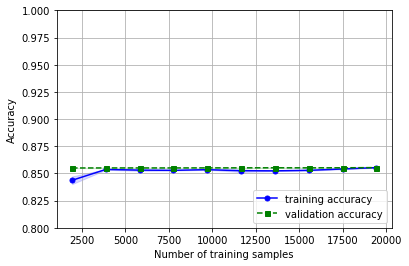

Test Accuracy: 0.855


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import make_pipeline

pipe_svm = make_pipeline(StandardScaler(),PCA(n_components=2),svm.SVC())

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svm,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

pipe_svm.fit(X_train, y_train)
y_svm_pred = pipe_svm.predict(X_test)
print('Test Accuracy: %.3f' % pipe_svm.score(X_test, y_test))

In [33]:
from sklearn import cross_validation
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


scores = cross_validation.cross_val_score(pipe_svm, X, y, cv=3)
print("cross_validation: {:.2f}".format(np.mean(scores, axis=0)))
print("f1 score: {:.2f}".format(f1_score(y_test, y_svm_pred,average='weighted')))
print("precision score: {:.2f}".format(precision_score(y_test, y_svm_pred, average='weighted')))

cross_validation: 0.86
f1 score: 0.79
precision score: 0.88


In [35]:
from sklearn.externals import joblib
joblib.dump(pipe_svm, 'app/models/svmpipeline.pkl')

model_columns = list(X.columns)
joblib.dump(model_columns, 'app/models/svm_model_columns.pkl')

['app/models/svm_model_columns.pkl']